In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter


In [2]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [3]:
# dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
#            "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
#            "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
#            "soil" : pd.read_csv("../src/soil_data.csv"),
#            }

In [4]:
# dataDic["train"].columns

In [5]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [6]:
# dfs = {
#     k: dataDic[k].set_index(['fips', 'date'])
#     for k in dataDic.keys() if k != "soil"
# }

# dfs["soil"] = dataDic["soil"]

In [7]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
one_cycle = True
lr = 9e-5
epochs = 15
clip = 5


In [8]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

In [9]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

In [10]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [11]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [12]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train")
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
# X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)

In [13]:
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True)
# print("test shape", X_time_test.shape)
# X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

In [14]:
# import pickle
# # export all
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy", X_tabular_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_train.npy", X_time_train)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_train.npy", y_target_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy", X_tabular_validation)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_valid.npy", X_time_valid)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_valid.npy", y_target_valid)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy", X_tabular_test)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_test.npy", X_time_test)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_test.npy", y_target_test)
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "wb") as f:
#     pickle.dump(valid_fips, f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "wb") as f:
#     pickle.dump(test_fips, f)


In [15]:
import pickle
# import all
X_tabular_train = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy")
X_time_train = np.load("../data/processed_no_cat_and_no_tensors/X_time_train.npy")
y_target_train = np.load("../data/processed_no_cat_and_no_tensors/y_target_train.npy")
X_tabular_validation = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy")
X_time_valid = np.load("../data/processed_no_cat_and_no_tensors/X_time_valid.npy")
y_target_valid = np.load("../data/processed_no_cat_and_no_tensors/y_target_valid.npy")
X_tabular_test = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy")
X_time_test = np.load("../data/processed_no_cat_and_no_tensors/X_time_test.npy")
y_target_test = np.load("../data/processed_no_cat_and_no_tensors/y_target_test.npy")
with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "rb") as f:
    valid_fips = pickle.load(f)
with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "rb") as f:
    test_fips = pickle.load(f)

In [16]:
y_train_tensor = torch.tensor(y_target_train[:, :output_weeks])

# Flatten the target tensor to compute class frequencies
flat_labels = y_train_tensor.view(-1).numpy().round().astype(int)  # Shape: [observations * weeks]
class_counts = np.bincount(flat_labels)  # Count occurrences of each class
class_weights = 1.0 / class_counts       # Inverse of class frequencies

# Map class weights to each [i, j] in the target tensor
weights_per_sample = class_weights[y_train_tensor.numpy().round().astype(int)]  # Shape: [observations, weeks]

# Compute the average weight per observation (averaging over the 6 weeks)
sample_weights = weights_per_sample.mean(axis=1)  # Shape: [observations]

# Create a sampler for the training data
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

# Prepare the datasets
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    y_train_tensor,
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(y_target_valid[:, :output_weeks]),
)

# DataLoaders with sampler for training and default for validation
train_loader = DataLoader(
    train_data, batch_size=batch_size, drop_last=False
)

valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [17]:
test_data = TensorDataset(
    torch.tensor(X_time_test),
    torch.tensor(X_tabular_test),
    torch.tensor(y_target_test[:, :output_weeks]),
)

test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [18]:
len(train_loader)

759

In [20]:
class HybridModel(nn.Module):
    def __init__(
        self,
        num_numerical_features,
        num_time_series_features,
        hidden_size,
        num_lstm_layers,
        num_fc_tabular_layers,
        num_fc_combined_layers,
        output_size,
        dropout
    ):
        super(HybridModel, self).__init__()
        self.num_lstm_layers = num_lstm_layers
        self.hidden_size = hidden_size

        tabular_fc_layers = []
        for _ in range(num_fc_tabular_layers):
            tabular_fc_layers.append(nn.Linear(num_numerical_features, num_numerical_features))
            tabular_fc_layers.append(nn.ReLU())
        self.tabular_fc_layers = nn.Sequential(
            *tabular_fc_layers, nn.Linear(num_numerical_features, num_numerical_features)
        )

        # TS branch
        self.lstm = nn.LSTM(
            input_size=num_time_series_features,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout,
        )

        self.dropout = nn.Dropout(dropout)

        combined_fc_layers = []
        input_dim = num_numerical_features + hidden_size

        for _ in range(num_fc_combined_layers):
            combined_fc_layers.append(nn.Linear(input_dim, hidden_size))
            combined_fc_layers.append(nn.ReLU())
            input_dim = hidden_size
        self.combined_fc_layers = nn.Sequential(
            *combined_fc_layers, nn.Linear(hidden_size, output_size)
        )

    def forward(self, time_series_data, numerical_data):
        batch_size = time_series_data.size(0)
        h0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)
        numerical_data = numerical_data.to(torch.float32)
        time_series_data = time_series_data.to(torch.float32)
        x1 = self.tabular_fc_layers(numerical_data)
        # Pass the time series data through the LSTM
        lstm_out, _ = self.lstm(time_series_data, (h0, c0))
        # Pass the data through the attention mechanism
        context_vector = lstm_out[:, -1, :]  # Last time step output
        x2 = self.dropout(context_vector)
        x = torch.cat((x1, x2), dim=1)
        x = self.combined_fc_layers(x)
        return x

In [20]:
writer = SummaryWriter('../runs/LSTM_0_each_batch')

In [21]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

model.to(device)
loss_function = nn.HuberLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)

for i in range(epochs):
    for k, (inputs, static, labels) in tqdm(enumerate(train_loader),
                                            desc=f"epoch {i+1}/{epochs}",
                                            total=len(train_loader),):
        model.train()
        counter += 1
        inputs, labels, static = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
        )
        model.zero_grad()
        output = model(inputs, static)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, lab in valid_loader:
                    inp, lab, stat = inp.to(device), lab.to(device), stat.to(device)
                    out = model(inp, stat)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(Hubber)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "../models/simple_lstm.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/15:  50%|█████     | 380/759 [02:11<09:09,  1.45s/it]

{'loss': 0.3622092604637146, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 1, 'validation_loss': np.float64(0.3175333870574832), 'macro_f1': np.float64(0.13810091378625347), 'micro_f1': np.float64(0.7073667073667074), 'mae': np.float64(0.5913538130786198)}
{'loss': 0.3622092604637146, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 2, 'validation_loss': np.float64(0.3175333870574832), 'macro_f1': np.float64(0.1388888888888889), 'micro_f1': np.float64(0.7142857142857143), 'mae': np.float64(0.5616276498536511)}
{'loss': 0.3622092604637146, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 3, 'validation_loss': np.float64(0.3175333870574832), 'macro_f1': np.float64(0.1404459098759617), 'micro_f1': np.float64(0.7281237281237282), 'mae': np.float64(0.5360316695644112)}
{'loss': 0.3622092604637146, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 4, 'validation_loss': np

epoch 1/15: 100%|██████████| 759/759 [04:24<00:00,  2.86it/s]


{'loss': 0.1018420085310936, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 1, 'validation_loss': np.float64(0.10445184912532568), 'macro_f1': np.float64(0.678144675688002), 'micro_f1': np.float64(0.870980870980871), 'mae': np.float64(0.2793065627640542)}
{'loss': 0.1018420085310936, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 2, 'validation_loss': np.float64(0.10445184912532568), 'macro_f1': np.float64(0.5405958263250031), 'micro_f1': np.float64(0.8376068376068376), 'mae': np.float64(0.2895608423790546)}
{'loss': 0.1018420085310936, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 3, 'validation_loss': np.float64(0.10445184912532568), 'macro_f1': np.float64(0.4883181333300996), 'micro_f1': np.float64(0.8095238095238095), 'mae': np.float64(0.30627562571706984)}
{'loss': 0.1018420085310936, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 4, 'validation_loss': np.float64(0.10445184912532568), 'macro_f1': np.float64(0

epoch 2/15:  50%|█████     | 380/759 [02:14<09:27,  1.50s/it]

{'loss': 0.10772198438644409, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 1, 'validation_loss': np.float64(0.08465113900601864), 'macro_f1': np.float64(0.6612579531468162), 'micro_f1': np.float64(0.8868538868538869), 'mae': np.float64(0.18312485950980723)}
{'loss': 0.10772198438644409, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 2, 'validation_loss': np.float64(0.08465113900601864), 'macro_f1': np.float64(0.5784610209019047), 'micro_f1': np.float64(0.8526658526658527), 'mae': np.float64(0.21677697112634017)}
{'loss': 0.10772198438644409, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 3, 'validation_loss': np.float64(0.08465113900601864), 'macro_f1': np.float64(0.5221494892895784), 'micro_f1': np.float64(0.8241758241758241), 'mae': np.float64(0.24848675364936013)}
{'loss': 0.10772198438644409, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 4, 'validat

epoch 2/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.07871590554714203, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 1, 'validation_loss': np.float64(0.09080648142844439), 'macro_f1': np.float64(0.7081833805927588), 'micro_f1': np.float64(0.8652828652828652), 'mae': np.float64(0.18563584415036752)}
{'loss': 0.07871590554714203, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 2, 'validation_loss': np.float64(0.09080648142844439), 'macro_f1': np.float64(0.6707118327505409), 'micro_f1': np.float64(0.8408628408628409), 'mae': np.float64(0.21759052956416766)}
{'loss': 0.07871590554714203, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 3, 'validation_loss': np.float64(0.09080648142844439), 'macro_f1': np.float64(0.6247786016305151), 'micro_f1': np.float64(0.816035816035816), 'mae': np.float64(0.254769111470829)}
{'loss': 0.07871590554714203, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 4, 'validation_loss': np.float64(0.09080648142844439), 'macro_f1': np.floa

epoch 3/15:  50%|█████     | 380/759 [02:13<09:12,  1.46s/it]

{'loss': 0.11043885350227356, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 1, 'validation_loss': np.float64(0.07895003389567137), 'macro_f1': np.float64(0.7138706314895525), 'micro_f1': np.float64(0.897028897028897), 'mae': np.float64(0.1449716019842287)}
{'loss': 0.11043885350227356, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 2, 'validation_loss': np.float64(0.07895003389567137), 'macro_f1': np.float64(0.6223946293057252), 'micro_f1': np.float64(0.8644688644688645), 'mae': np.float64(0.18400718635699015)}
{'loss': 0.11043885350227356, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 3, 'validation_loss': np.float64(0.07895003389567137), 'macro_f1': np.float64(0.5338014067202081), 'micro_f1': np.float64(0.8315018315018315), 'mae': np.float64(0.23004878301740325)}
{'loss': 0.11043885350227356, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 4, 'validatio

epoch 3/15: 100%|██████████| 759/759 [04:26<00:00,  2.84it/s]


{'loss': 0.06806940585374832, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 1, 'validation_loss': np.float64(0.0754947536624968), 'macro_f1': np.float64(0.775945453735439), 'micro_f1': np.float64(0.9035409035409036), 'mae': np.float64(0.13537251851107104)}
{'loss': 0.06806940585374832, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 2, 'validation_loss': np.float64(0.0754947536624968), 'macro_f1': np.float64(0.7150087231519674), 'micro_f1': np.float64(0.8693528693528694), 'mae': np.float64(0.17867659228837643)}
{'loss': 0.06806940585374832, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 3, 'validation_loss': np.float64(0.0754947536624968), 'macro_f1': np.float64(0.6642566809132631), 'micro_f1': np.float64(0.8371998371998371), 'mae': np.float64(0.2236149237108985)}
{'loss': 0.06806940585374832, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 4, 'validation_loss': np.float64(0.0754947536624968), 'macro_f1': np.float64

epoch 4/15:  50%|█████     | 380/759 [02:13<09:12,  1.46s/it]

{'loss': 0.10854829847812653, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 1, 'validation_loss': np.float64(0.073873729724437), 'macro_f1': np.float64(0.7024550796075489), 'micro_f1': np.float64(0.9031339031339032), 'mae': np.float64(0.1267725659804867)}
{'loss': 0.10854829847812653, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 2, 'validation_loss': np.float64(0.073873729724437), 'macro_f1': np.float64(0.6288728223707222), 'micro_f1': np.float64(0.8685388685388685), 'mae': np.float64(0.1725323993734718)}
{'loss': 0.10854829847812653, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 3, 'validation_loss': np.float64(0.073873729724437), 'macro_f1': np.float64(0.5329881515059443), 'micro_f1': np.float64(0.8359788359788359), 'mae': np.float64(0.22087032446712926)}
{'loss': 0.10854829847812653, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 4, 'validation_loss': n

epoch 4/15: 100%|██████████| 759/759 [04:26<00:00,  2.84it/s]


{'loss': 0.06226310878992081, 'epoch': 4.0, 'step': 3036, 'lr': 8.740679149978162e-05, 'week': 1, 'validation_loss': np.float64(0.07922748168930412), 'macro_f1': np.float64(0.7632201507404619), 'micro_f1': np.float64(0.897028897028897), 'mae': np.float64(0.133526558082824)}
{'loss': 0.06226310878992081, 'epoch': 4.0, 'step': 3036, 'lr': 8.740679149978162e-05, 'week': 2, 'validation_loss': np.float64(0.07922748168930412), 'macro_f1': np.float64(0.714959748178971), 'micro_f1': np.float64(0.8603988603988604), 'mae': np.float64(0.1765611672114467)}
{'loss': 0.06226310878992081, 'epoch': 4.0, 'step': 3036, 'lr': 8.740679149978162e-05, 'week': 3, 'validation_loss': np.float64(0.07922748168930412), 'macro_f1': np.float64(0.6704425154483243), 'micro_f1': np.float64(0.8323158323158323), 'mae': np.float64(0.22194338920315346)}
{'loss': 0.06226310878992081, 'epoch': 4.0, 'step': 3036, 'lr': 8.740679149978162e-05, 'week': 4, 'validation_loss': np.float64(0.07922748168930412), 'macro_f1': np.float6

epoch 5/15:  50%|█████     | 380/759 [02:13<09:09,  1.45s/it]

{'loss': 0.10241370648145676, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 8.999999213314978e-05, 'week': 1, 'validation_loss': np.float64(0.07149281604215503), 'macro_f1': np.float64(0.7428332800772063), 'micro_f1': np.float64(0.9124949124949125), 'mae': np.float64(0.11348650190581941)}
{'loss': 0.10241370648145676, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 8.999999213314978e-05, 'week': 2, 'validation_loss': np.float64(0.07149281604215503), 'macro_f1': np.float64(0.5917693711763738), 'micro_f1': np.float64(0.8673178673178673), 'mae': np.float64(0.1656449832580932)}
{'loss': 0.10241370648145676, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 8.999999213314978e-05, 'week': 3, 'validation_loss': np.float64(0.07149281604215503), 'macro_f1': np.float64(0.5221565132357618), 'micro_f1': np.float64(0.8331298331298331), 'mae': np.float64(0.2102611737613228)}
{'loss': 0.10241370648145676, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 8.999999213314978e-05, 'week': 4, 'validation_lo

epoch 5/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.06105082482099533, 'epoch': 5.0, 'step': 3795, 'lr': 8.949474186988228e-05, 'week': 1, 'validation_loss': np.float64(0.07803833289071918), 'macro_f1': np.float64(0.7810610943154019), 'micro_f1': np.float64(0.9055759055759056), 'mae': np.float64(0.12167568314233275)}
{'loss': 0.06105082482099533, 'epoch': 5.0, 'step': 3795, 'lr': 8.949474186988228e-05, 'week': 2, 'validation_loss': np.float64(0.07803833289071918), 'macro_f1': np.float64(0.7175008586812096), 'micro_f1': np.float64(0.8660968660968661), 'mae': np.float64(0.1707004126158905)}
{'loss': 0.06105082482099533, 'epoch': 5.0, 'step': 3795, 'lr': 8.949474186988228e-05, 'week': 3, 'validation_loss': np.float64(0.07803833289071918), 'macro_f1': np.float64(0.667859055820062), 'micro_f1': np.float64(0.8347578347578347), 'mae': np.float64(0.21799614340834347)}
{'loss': 0.06105082482099533, 'epoch': 5.0, 'step': 3795, 'lr': 8.949474186988228e-05, 'week': 4, 'validation_loss': np.float64(0.07803833289071918), 'macro_f1': np.flo

epoch 6/15:  50%|█████     | 380/759 [02:13<09:11,  1.46s/it]

{'loss': 0.09917767345905304, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 8.799293373936494e-05, 'week': 1, 'validation_loss': np.float64(0.07079280773177743), 'macro_f1': np.float64(0.8136287190954347), 'micro_f1': np.float64(0.9214489214489214), 'mae': np.float64(0.10652381441293934)}
{'loss': 0.09917767345905304, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 8.799293373936494e-05, 'week': 2, 'validation_loss': np.float64(0.07079280773177743), 'macro_f1': np.float64(0.5942608796708749), 'micro_f1': np.float64(0.8689458689458689), 'mae': np.float64(0.16062045102331773)}
{'loss': 0.09917767345905304, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 8.799293373936494e-05, 'week': 3, 'validation_loss': np.float64(0.07079280773177743), 'macro_f1': np.float64(0.5145554571706802), 'micro_f1': np.float64(0.833943833943834), 'mae': np.float64(0.20600707941909827)}
{'loss': 0.09917767345905304, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 8.799293373936494e-05, 'week': 4, 'validation_l

epoch 6/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.06616555899381638, 'epoch': 6.0, 'step': 4554, 'lr': 8.553591705982761e-05, 'week': 1, 'validation_loss': np.float64(0.07674156203866005), 'macro_f1': np.float64(0.770037574003838), 'micro_f1': np.float64(0.9084249084249084), 'mae': np.float64(0.12447675814396927)}
{'loss': 0.06616555899381638, 'epoch': 6.0, 'step': 4554, 'lr': 8.553591705982761e-05, 'week': 2, 'validation_loss': np.float64(0.07674156203866005), 'macro_f1': np.float64(0.7067550009388631), 'micro_f1': np.float64(0.8701668701668702), 'mae': np.float64(0.17318412749653408)}
{'loss': 0.06616555899381638, 'epoch': 6.0, 'step': 4554, 'lr': 8.553591705982761e-05, 'week': 3, 'validation_loss': np.float64(0.07674156203866005), 'macro_f1': np.float64(0.6575710696006052), 'micro_f1': np.float64(0.8376068376068376), 'mae': np.float64(0.2199054980099541)}
{'loss': 0.06616555899381638, 'epoch': 6.0, 'step': 4554, 'lr': 8.553591705982761e-05, 'week': 4, 'validation_loss': np.float64(0.07674156203866005), 'macro_f1': np.flo

epoch 7/15:  50%|█████     | 380/759 [02:13<09:10,  1.45s/it]

{'loss': 0.09699632972478867, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 8.216578050524531e-05, 'week': 1, 'validation_loss': np.float64(0.07028158130124211), 'macro_f1': np.float64(0.8090609278448165), 'micro_f1': np.float64(0.9181929181929182), 'mae': np.float64(0.10845265429252207)}
{'loss': 0.09699632972478867, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 8.216578050524531e-05, 'week': 2, 'validation_loss': np.float64(0.07028158130124211), 'macro_f1': np.float64(0.5960497645319144), 'micro_f1': np.float64(0.8701668701668702), 'mae': np.float64(0.1603521996413298)}
{'loss': 0.09699632972478867, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 8.216578050524531e-05, 'week': 3, 'validation_loss': np.float64(0.07028158130124211), 'macro_f1': np.float64(0.5092489369058733), 'micro_f1': np.float64(0.8323158323158323), 'mae': np.float64(0.20498549920173867)}
{'loss': 0.09699632972478867, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 8.216578050524531e-05, 'week': 4, 'validation_l

epoch 7/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.06490065157413483, 'epoch': 7.0, 'step': 5313, 'lr': 7.797531412385515e-05, 'week': 1, 'validation_loss': np.float64(0.07461934303864837), 'macro_f1': np.float64(0.8077204891027959), 'micro_f1': np.float64(0.9141229141229141), 'mae': np.float64(0.12106805697919198)}
{'loss': 0.06490065157413483, 'epoch': 7.0, 'step': 5313, 'lr': 7.797531412385515e-05, 'week': 2, 'validation_loss': np.float64(0.07461934303864837), 'macro_f1': np.float64(0.7127182489037484), 'micro_f1': np.float64(0.8717948717948718), 'mae': np.float64(0.1736832496968581)}
{'loss': 0.06490065157413483, 'epoch': 7.0, 'step': 5313, 'lr': 7.797531412385515e-05, 'week': 3, 'validation_loss': np.float64(0.07461934303864837), 'macro_f1': np.float64(0.6655089480061069), 'micro_f1': np.float64(0.8420838420838421), 'mae': np.float64(0.22202490796561547)}
{'loss': 0.06490065157413483, 'epoch': 7.0, 'step': 5313, 'lr': 7.797531412385515e-05, 'week': 4, 'validation_loss': np.float64(0.07461934303864837), 'macro_f1': np.fl

epoch 8/15:  50%|█████     | 380/759 [02:13<09:10,  1.45s/it]

{'loss': 0.09589468687772751, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 7.303630056768322e-05, 'week': 1, 'validation_loss': np.float64(0.06936784563586115), 'macro_f1': np.float64(0.8088543863455286), 'micro_f1': np.float64(0.919006919006919), 'mae': np.float64(0.10940204009702767)}
{'loss': 0.09589468687772751, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 7.303630056768322e-05, 'week': 2, 'validation_loss': np.float64(0.06936784563586115), 'macro_f1': np.float64(0.6302670572419029), 'micro_f1': np.float64(0.8722018722018722), 'mae': np.float64(0.15981653749085523)}
{'loss': 0.09589468687772751, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 7.303630056768322e-05, 'week': 3, 'validation_loss': np.float64(0.06936784563586115), 'macro_f1': np.float64(0.5324977625004339), 'micro_f1': np.float64(0.8363858363858364), 'mae': np.float64(0.20313985519517255)}
{'loss': 0.09589468687772751, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 7.303630056768322e-05, 'week': 4, 'validation_l

epoch 8/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.06262222677469254, 'epoch': 8.0, 'step': 6072, 'lr': 6.748472581198555e-05, 'week': 1, 'validation_loss': np.float64(0.07528931563720107), 'macro_f1': np.float64(0.81921145515551), 'micro_f1': np.float64(0.9185999185999186), 'mae': np.float64(0.121144228614649)}
{'loss': 0.06262222677469254, 'epoch': 8.0, 'step': 6072, 'lr': 6.748472581198555e-05, 'week': 2, 'validation_loss': np.float64(0.07528931563720107), 'macro_f1': np.float64(0.7490411478253853), 'micro_f1': np.float64(0.8762718762718763), 'mae': np.float64(0.18011582267311566)}
{'loss': 0.06262222677469254, 'epoch': 8.0, 'step': 6072, 'lr': 6.748472581198555e-05, 'week': 3, 'validation_loss': np.float64(0.07528931563720107), 'macro_f1': np.float64(0.6975416919657121), 'micro_f1': np.float64(0.8428978428978429), 'mae': np.float64(0.23007335814818966)}
{'loss': 0.06262222677469254, 'epoch': 8.0, 'step': 6072, 'lr': 6.748472581198555e-05, 'week': 4, 'validation_loss': np.float64(0.07528931563720107), 'macro_f1': np.float

epoch 9/15:  50%|█████     | 380/759 [02:13<09:07,  1.44s/it]

{'loss': 0.09790482372045517, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 6.141568828319385e-05, 'week': 1, 'validation_loss': np.float64(0.07082081949338317), 'macro_f1': np.float64(0.7307295840099207), 'micro_f1': np.float64(0.9165649165649166), 'mae': np.float64(0.11057562761445282)}
{'loss': 0.09790482372045517, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 6.141568828319385e-05, 'week': 2, 'validation_loss': np.float64(0.07082081949338317), 'macro_f1': np.float64(0.5920723467923841), 'micro_f1': np.float64(0.8665038665038665), 'mae': np.float64(0.1635996658932049)}
{'loss': 0.09790482372045517, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 6.141568828319385e-05, 'week': 3, 'validation_loss': np.float64(0.07082081949338317), 'macro_f1': np.float64(0.4920654235728363), 'micro_f1': np.float64(0.8302808302808303), 'mae': np.float64(0.20784979219066696)}
{'loss': 0.09790482372045517, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 6.141568828319385e-05, 'week': 4, 'validation_l

epoch 9/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.0648164376616478, 'epoch': 9.0, 'step': 6831, 'lr': 5.4996286932916974e-05, 'week': 1, 'validation_loss': np.float64(0.07780046807602048), 'macro_f1': np.float64(0.8051484241840613), 'micro_f1': np.float64(0.9120879120879121), 'mae': np.float64(0.1275545336533755)}
{'loss': 0.0648164376616478, 'epoch': 9.0, 'step': 6831, 'lr': 5.4996286932916974e-05, 'week': 2, 'validation_loss': np.float64(0.07780046807602048), 'macro_f1': np.float64(0.7432148243219817), 'micro_f1': np.float64(0.8697598697598697), 'mae': np.float64(0.18710750770349607)}
{'loss': 0.0648164376616478, 'epoch': 9.0, 'step': 6831, 'lr': 5.4996286932916974e-05, 'week': 3, 'validation_loss': np.float64(0.07780046807602048), 'macro_f1': np.float64(0.690584777604855), 'micro_f1': np.float64(0.8367928367928368), 'mae': np.float64(0.23692030806367748)}
{'loss': 0.0648164376616478, 'epoch': 9.0, 'step': 6831, 'lr': 5.4996286932916974e-05, 'week': 4, 'validation_loss': np.float64(0.07780046807602048), 'macro_f1': np.flo

epoch 10/15:  50%|█████     | 380/759 [02:13<09:20,  1.48s/it]

{'loss': 0.0965486392378807, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 4.8336486049471124e-05, 'week': 1, 'validation_loss': np.float64(0.06999631170183421), 'macro_f1': np.float64(0.7714202329516668), 'micro_f1': np.float64(0.9169719169719169), 'mae': np.float64(0.1073377885840351)}
{'loss': 0.0965486392378807, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 4.8336486049471124e-05, 'week': 2, 'validation_loss': np.float64(0.06999631170183421), 'macro_f1': np.float64(0.6070533025184943), 'micro_f1': np.float64(0.8697598697598697), 'mae': np.float64(0.16100064718471369)}
{'loss': 0.0965486392378807, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 4.8336486049471124e-05, 'week': 3, 'validation_loss': np.float64(0.06999631170183421), 'macro_f1': np.float64(0.537482438247681), 'micro_f1': np.float64(0.8335368335368335), 'mae': np.float64(0.20653900437375783)}
{'loss': 0.0965486392378807, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 4.8336486049471124e-05, 'week': 4, 'validation_lo

epoch 10/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.06399232894182205, 'epoch': 10.0, 'step': 7590, 'lr': 4.161965008566596e-05, 'week': 1, 'validation_loss': np.float64(0.0812695230357349), 'macro_f1': np.float64(0.7835728329651518), 'micro_f1': np.float64(0.9010989010989011), 'mae': np.float64(0.14764564881805342)}
{'loss': 0.06399232894182205, 'epoch': 10.0, 'step': 7590, 'lr': 4.161965008566596e-05, 'week': 2, 'validation_loss': np.float64(0.0812695230357349), 'macro_f1': np.float64(0.7281446017154701), 'micro_f1': np.float64(0.8628408628408628), 'mae': np.float64(0.19981763610161377)}
{'loss': 0.06399232894182205, 'epoch': 10.0, 'step': 7590, 'lr': 4.161965008566596e-05, 'week': 3, 'validation_loss': np.float64(0.0812695230357349), 'macro_f1': np.float64(0.6858237176424171), 'micro_f1': np.float64(0.8319088319088319), 'mae': np.float64(0.24643806929818052)}
{'loss': 0.06399232894182205, 'epoch': 10.0, 'step': 7590, 'lr': 4.161965008566596e-05, 'week': 4, 'validation_loss': np.float64(0.0812695230357349), 'macro_f1': np.f

epoch 11/15:  50%|█████     | 380/759 [02:13<09:10,  1.45s/it]

{'loss': 0.09602739661931992, 'epoch': 10.500658761528326, 'step': 7970, 'lr': 3.496083838211498e-05, 'week': 1, 'validation_loss': np.float64(0.06767691252753139), 'macro_f1': np.float64(0.8266954846759339), 'micro_f1': np.float64(0.9202279202279202), 'mae': np.float64(0.10588893200755846)}
{'loss': 0.09602739661931992, 'epoch': 10.500658761528326, 'step': 7970, 'lr': 3.496083838211498e-05, 'week': 2, 'validation_loss': np.float64(0.06767691252753139), 'macro_f1': np.float64(0.7352134653074898), 'micro_f1': np.float64(0.8774928774928775), 'mae': np.float64(0.15848072154342122)}
{'loss': 0.09602739661931992, 'epoch': 10.500658761528326, 'step': 7970, 'lr': 3.496083838211498e-05, 'week': 3, 'validation_loss': np.float64(0.06767691252753139), 'macro_f1': np.float64(0.6571604737865236), 'micro_f1': np.float64(0.8424908424908425), 'mae': np.float64(0.20168065786976117)}
{'loss': 0.09602739661931992, 'epoch': 10.500658761528326, 'step': 7970, 'lr': 3.496083838211498e-05, 'week': 4, 'validat

epoch 11/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.06529298424720764, 'epoch': 11.0, 'step': 8349, 'lr': 2.8543388156514706e-05, 'week': 1, 'validation_loss': np.float64(0.08168857842683792), 'macro_f1': np.float64(0.7682787059298986), 'micro_f1': np.float64(0.8982498982498982), 'mae': np.float64(0.16470439703983047)}
{'loss': 0.06529298424720764, 'epoch': 11.0, 'step': 8349, 'lr': 2.8543388156514706e-05, 'week': 2, 'validation_loss': np.float64(0.08168857842683792), 'macro_f1': np.float64(0.7125989238986183), 'micro_f1': np.float64(0.8567358567358567), 'mae': np.float64(0.21178270870180796)}
{'loss': 0.06529298424720764, 'epoch': 11.0, 'step': 8349, 'lr': 2.8543388156514706e-05, 'week': 3, 'validation_loss': np.float64(0.08168857842683792), 'macro_f1': np.float64(0.6871368149761494), 'micro_f1': np.float64(0.8310948310948311), 'mae': np.float64(0.25596332770119146)}
{'loss': 0.06529298424720764, 'epoch': 11.0, 'step': 8349, 'lr': 2.8543388156514706e-05, 'week': 4, 'validation_loss': np.float64(0.08168857842683792), 'macro_f

epoch 12/15:  50%|█████     | 380/759 [02:13<09:11,  1.46s/it]

{'loss': 0.09467735141515732, 'epoch': 11.500658761528326, 'step': 8729, 'lr': 2.2477230274432936e-05, 'week': 1, 'validation_loss': np.float64(0.06728406082838774), 'macro_f1': np.float64(0.8354711333714221), 'micro_f1': np.float64(0.9185999185999186), 'mae': np.float64(0.10990927211118148)}
{'loss': 0.09467735141515732, 'epoch': 11.500658761528326, 'step': 8729, 'lr': 2.2477230274432936e-05, 'week': 2, 'validation_loss': np.float64(0.06728406082838774), 'macro_f1': np.float64(0.7468781229586888), 'micro_f1': np.float64(0.8762718762718763), 'mae': np.float64(0.16114795520254932)}
{'loss': 0.09467735141515732, 'epoch': 11.500658761528326, 'step': 8729, 'lr': 2.2477230274432936e-05, 'week': 3, 'validation_loss': np.float64(0.06728406082838774), 'macro_f1': np.float64(0.6592502360337122), 'micro_f1': np.float64(0.8441188441188441), 'mae': np.float64(0.20320870240202973)}
{'loss': 0.09467735141515732, 'epoch': 11.500658761528326, 'step': 8729, 'lr': 2.2477230274432936e-05, 'week': 4, 'val

epoch 12/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.06617854535579681, 'epoch': 12.0, 'step': 9108, 'lr': 1.6929384402098612e-05, 'week': 1, 'validation_loss': np.float64(0.07380025517195463), 'macro_f1': np.float64(0.8017034424320336), 'micro_f1': np.float64(0.9116809116809117), 'mae': np.float64(0.13175940997199065)}
{'loss': 0.06617854535579681, 'epoch': 12.0, 'step': 9108, 'lr': 1.6929384402098612e-05, 'week': 2, 'validation_loss': np.float64(0.07380025517195463), 'macro_f1': np.float64(0.731945726207099), 'micro_f1': np.float64(0.8665038665038665), 'mae': np.float64(0.18233770951241812)}
{'loss': 0.06617854535579681, 'epoch': 12.0, 'step': 9108, 'lr': 1.6929384402098612e-05, 'week': 3, 'validation_loss': np.float64(0.07380025517195463), 'macro_f1': np.float64(0.714602227057401), 'micro_f1': np.float64(0.8412698412698413), 'mae': np.float64(0.22739916116308165)}
{'loss': 0.06617854535579681, 'epoch': 12.0, 'step': 9108, 'lr': 1.6929384402098612e-05, 'week': 4, 'validation_loss': np.float64(0.07380025517195463), 'macro_f1'

epoch 13/15:  50%|█████     | 380/759 [02:13<09:10,  1.45s/it]

{'loss': 0.09236881136894226, 'epoch': 12.500658761528326, 'step': 9488, 'lr': 1.1994885090204386e-05, 'week': 1, 'validation_loss': np.float64(0.06665226835757494), 'macro_f1': np.float64(0.8000165210989937), 'micro_f1': np.float64(0.9210419210419211), 'mae': np.float64(0.10624528779286557)}
{'loss': 0.09236881136894226, 'epoch': 12.500658761528326, 'step': 9488, 'lr': 1.1994885090204386e-05, 'week': 2, 'validation_loss': np.float64(0.06665226835757494), 'macro_f1': np.float64(0.7325576347053397), 'micro_f1': np.float64(0.8783068783068783), 'mae': np.float64(0.16032936253041138)}
{'loss': 0.09236881136894226, 'epoch': 12.500658761528326, 'step': 9488, 'lr': 1.1994885090204386e-05, 'week': 3, 'validation_loss': np.float64(0.06665226835757494), 'macro_f1': np.float64(0.6346732958335215), 'micro_f1': np.float64(0.8441188441188441), 'mae': np.float64(0.20544940540462694)}
{'loss': 0.09236881136894226, 'epoch': 12.500658761528326, 'step': 9488, 'lr': 1.1994885090204386e-05, 'week': 4, 'val

epoch 13/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.06926786154508591, 'epoch': 13.0, 'step': 9867, 'lr': 7.809594023213535e-06, 'week': 1, 'validation_loss': np.float64(0.06756892763078212), 'macro_f1': np.float64(0.8375292681523173), 'micro_f1': np.float64(0.9214489214489214), 'mae': np.float64(0.10518387628637245)}
{'loss': 0.06926786154508591, 'epoch': 13.0, 'step': 9867, 'lr': 7.809594023213535e-06, 'week': 2, 'validation_loss': np.float64(0.06756892763078212), 'macro_f1': np.float64(0.7560559851174072), 'micro_f1': np.float64(0.8783068783068783), 'mae': np.float64(0.1582471459277238)}
{'loss': 0.06926786154508591, 'epoch': 13.0, 'step': 9867, 'lr': 7.809594023213535e-06, 'week': 3, 'validation_loss': np.float64(0.06756892763078212), 'macro_f1': np.float64(0.679777223052559), 'micro_f1': np.float64(0.8490028490028491), 'mae': np.float64(0.20455293923445447)}
{'loss': 0.06926786154508591, 'epoch': 13.0, 'step': 9867, 'lr': 7.809594023213535e-06, 'week': 4, 'validation_loss': np.float64(0.06756892763078212), 'macro_f1': np

epoch 14/15:  50%|█████     | 380/759 [02:13<09:12,  1.46s/it]

{'loss': 0.09311240911483765, 'epoch': 13.500658761528326, 'step': 10247, 'lr': 4.445205200062238e-06, 'week': 1, 'validation_loss': np.float64(0.06654509110376239), 'macro_f1': np.float64(0.827480562301234), 'micro_f1': np.float64(0.9222629222629223), 'mae': np.float64(0.10338193092516976)}
{'loss': 0.09311240911483765, 'epoch': 13.500658761528326, 'step': 10247, 'lr': 4.445205200062238e-06, 'week': 2, 'validation_loss': np.float64(0.06654509110376239), 'macro_f1': np.float64(0.7292242188616375), 'micro_f1': np.float64(0.8787138787138787), 'mae': np.float64(0.1560471917931802)}
{'loss': 0.09311240911483765, 'epoch': 13.500658761528326, 'step': 10247, 'lr': 4.445205200062238e-06, 'week': 3, 'validation_loss': np.float64(0.06654509110376239), 'macro_f1': np.float64(0.6515959590223942), 'micro_f1': np.float64(0.8445258445258446), 'mae': np.float64(0.2007962062083588)}
{'loss': 0.09311240911483765, 'epoch': 13.500658761528326, 'step': 10247, 'lr': 4.445205200062238e-06, 'week': 4, 'valida

epoch 14/15: 100%|██████████| 759/759 [04:27<00:00,  2.84it/s]


{'loss': 0.06565214693546295, 'epoch': 14.0, 'step': 10626, 'lr': 1.9943504165642993e-06, 'week': 1, 'validation_loss': np.float64(0.06512576891109348), 'macro_f1': np.float64(0.8284190779246345), 'micro_f1': np.float64(0.9222629222629223), 'mae': np.float64(0.09634352753186523)}
{'loss': 0.06565214693546295, 'epoch': 14.0, 'step': 10626, 'lr': 1.9943504165642993e-06, 'week': 2, 'validation_loss': np.float64(0.06512576891109348), 'macro_f1': np.float64(0.7641074311258839), 'micro_f1': np.float64(0.8787138787138787), 'mae': np.float64(0.14731588974590581)}
{'loss': 0.06565214693546295, 'epoch': 14.0, 'step': 10626, 'lr': 1.9943504165642993e-06, 'week': 3, 'validation_loss': np.float64(0.06512576891109348), 'macro_f1': np.float64(0.7071765089613308), 'micro_f1': np.float64(0.8453398453398453), 'mae': np.float64(0.19161256630818474)}
{'loss': 0.06565214693546295, 'epoch': 14.0, 'step': 10626, 'lr': 1.9943504165642993e-06, 'week': 4, 'validation_loss': np.float64(0.06512576891109348), 'mac

epoch 15/15:  50%|█████     | 380/759 [02:13<09:07,  1.44s/it]

{'loss': 0.09462825953960419, 'epoch': 14.500658761528326, 'step': 11006, 'lr': 4.990127934700871e-07, 'week': 1, 'validation_loss': np.float64(0.06715828878805041), 'macro_f1': np.float64(0.8280787531088708), 'micro_f1': np.float64(0.9214489214489214), 'mae': np.float64(0.10164798753156039)}
{'loss': 0.09462825953960419, 'epoch': 14.500658761528326, 'step': 11006, 'lr': 4.990127934700871e-07, 'week': 2, 'validation_loss': np.float64(0.06715828878805041), 'macro_f1': np.float64(0.7631722672293945), 'micro_f1': np.float64(0.87993487993488), 'mae': np.float64(0.15471604968636476)}
{'loss': 0.09462825953960419, 'epoch': 14.500658761528326, 'step': 11006, 'lr': 4.990127934700871e-07, 'week': 3, 'validation_loss': np.float64(0.06715828878805041), 'macro_f1': np.float64(0.7216195184247024), 'micro_f1': np.float64(0.8494098494098494), 'mae': np.float64(0.20061141614451258)}
{'loss': 0.09462825953960419, 'epoch': 14.500658761528326, 'step': 11006, 'lr': 4.990127934700871e-07, 'week': 4, 'valid

epoch 15/15: 100%|██████████| 759/759 [04:26<00:00,  2.84it/s]

{'loss': 0.06333456188440323, 'epoch': 15.0, 'step': 11385, 'lr': 3.6349637793541974e-10, 'week': 1, 'validation_loss': np.float64(0.06701326817274093), 'macro_f1': np.float64(0.8264278628869491), 'micro_f1': np.float64(0.9214489214489214), 'mae': np.float64(0.10098549324822684)}
{'loss': 0.06333456188440323, 'epoch': 15.0, 'step': 11385, 'lr': 3.6349637793541974e-10, 'week': 2, 'validation_loss': np.float64(0.06701326817274093), 'macro_f1': np.float64(0.7597676288815021), 'micro_f1': np.float64(0.87993487993488), 'mae': np.float64(0.1537635049359187)}
{'loss': 0.06333456188440323, 'epoch': 15.0, 'step': 11385, 'lr': 3.6349637793541974e-10, 'week': 3, 'validation_loss': np.float64(0.06701326817274093), 'macro_f1': np.float64(0.7117762253493835), 'micro_f1': np.float64(0.8494098494098494), 'mae': np.float64(0.19931940607411205)}
{'loss': 0.06333456188440323, 'epoch': 15.0, 'step': 11385, 'lr': 3.6349637793541974e-10, 'week': 4, 'validation_loss': np.float64(0.06701326817274093), 'macro_

In [21]:
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("../models/simple_lstm.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel(
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
  )
  (lstm): LSTM(40, 512, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=542, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [22]:
def predict(x, static):
    out = model(torch.tensor(x), static)
    return out

In [23]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, y in tqdm(
    test_loader, # ou test_loader
    desc="validation predictions...",):
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1493029/4252433048.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(x), static)
validation predictions...: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


In [31]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
VALIDATION_no_prev_year:
Week 1 MAE 0.119 F1 0.818
Week 2 MAE 0.189 F1 0.735
Week 3 MAE 0.247 F1 0.661
Week 4 MAE 0.3 F1 0.592
Week 5 MAE 0.346 F1 0.534
Week 6 MAE 0.386 F1 0.491

TEST_no_prev_year:
Week 1 MAE 0.113 F1 0.816
Week 2 MAE 0.184 F1 0.69
Week 3 MAE 0.243 F1 0.591
Week 4 MAE 0.297 F1 0.531
Week 5 MAE 0.34 F1 0.484
Week 6 MAE 0.379 F1 0.441

VALIDATION:
Week 1 MAE 0.098 F1 0.833
Week 2 MAE 0.147 F1 0.765
Week 3 MAE 0.191 F1 0.711
Week 4 MAE 0.229 F1 0.687
Week 5 MAE 0.258 F1 0.618
Week 6 MAE 0.285 F1 0.571

TEST:
Week 1 MAE 0.13 F1 0.78
Week 2 MAE 0.214 F1 0.702
Week 3 MAE 0.274 F1 0.625
Week 4 MAE 0.336 F1 0.551
Week 5 MAE 0.383 F1 0.498
Week 6 MAE 0.423 F1 0.461
"""

Week 1 MAE 0.131 F1 0.8
Week 2 MAE 0.215 F1 0.688
Week 3 MAE 0.274 F1 0.609
Week 4 MAE 0.336 F1 0.543
Week 5 MAE 0.382 F1 0.492
Week 6 MAE 0.423 F1 0.46


'\nVALIDATION_no_prev_year:\nWeek 1 MAE 0.119 F1 0.818\nWeek 2 MAE 0.189 F1 0.735\nWeek 3 MAE 0.247 F1 0.661\nWeek 4 MAE 0.3 F1 0.592\nWeek 5 MAE 0.346 F1 0.534\nWeek 6 MAE 0.386 F1 0.491\n\nTEST_no_prev_year:\nWeek 1 MAE 0.113 F1 0.816\nWeek 2 MAE 0.184 F1 0.69\nWeek 3 MAE 0.243 F1 0.591\nWeek 4 MAE 0.297 F1 0.531\nWeek 5 MAE 0.34 F1 0.484\nWeek 6 MAE 0.379 F1 0.441\n\nVALIDATION:\nWeek 1 MAE 0.098 F1 0.833\nWeek 2 MAE 0.147 F1 0.765\nWeek 3 MAE 0.191 F1 0.711\nWeek 4 MAE 0.229 F1 0.687\nWeek 5 MAE 0.258 F1 0.618\nWeek 6 MAE 0.285 F1 0.571\n\nTEST:\nWeek 1 MAE 0.13 F1 0.78\nWeek 2 MAE 0.214 F1 0.702\nWeek 3 MAE 0.274 F1 0.625\nWeek 4 MAE 0.336 F1 0.551\nWeek 5 MAE 0.383 F1 0.498\nWeek 6 MAE 0.423 F1 0.461\n'

In [32]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.019651,0,0.0000,0
1,0.007154,0,0.0000,0
2,0.049476,0,0.0000,0
3,0.061679,0,0.0000,0
4,0.001366,0,0.0000,0
...,...,...,...,...
14857,2.896903,3,2.8139,5
14858,3.317130,3,3.1832,5
14859,2.764792,3,2.7126,5
14860,1.756137,2,2.0000,5


In [33]:
for cat in df["y_true"].round().astype(int).unique():
    df_cat = df[df["y_true"].round().astype(int) == cat]
    print(f"Accuracy {cat}:")
    print((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())

Accuracy 0:
0.9188568805233559
Accuracy 1:
0.5319225251076041
Accuracy 3:
0.5699797160243407
Accuracy 4:
0.5825049701789264
Accuracy 2:
0.5028935185185185
Accuracy 5:
0.2222222222222222


In [34]:
# F1 by week
for w in range(6):
    wdf = df[df['week']==w]
    print(f"Week {w+1}", f"F1 {f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)}")

Week 1 F1 0.8
Week 2 F1 0.688
Week 3 F1 0.609
Week 4 F1 0.543
Week 5 F1 0.492
Week 6 F1 0.46


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, root_mean_squared_error
y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
# do a table using print in the terminal
print("  MAE  | RMSE  |  F1  ")
print(f"{mae} | {rmse} | {f1}")

'''
TEST_no_prev_year:
 MAE  | RMSE  |  F1  
0.259273340796143 | 0.46515011853669513 | 0.5818472863599845
'''

  MAE  | RMSE  |  F1  
0.293514137941059 | 0.4806828838562505 | 0.5949766106201791


'\nTEST_no_prev_year:\n MAE  | RMSE  |  F1  \n0.259273340796143 | 0.46515011853669513 | 0.5818472863599845\n'

: 

(array([4.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 7.000e+00,
        1.600e+01, 1.500e+01, 4.000e+00, 3.000e+01, 2.400e+01, 4.100e+01,
        8.300e+01, 1.150e+02, 1.590e+02, 2.260e+02, 4.010e+02, 1.052e+03,
        2.828e+03, 5.379e+03, 9.690e+02, 7.880e+02, 5.870e+02, 5.630e+02,
        5.540e+02, 4.170e+02, 1.800e+02, 1.180e+02, 6.700e+01, 7.000e+01,
        6.000e+01, 5.600e+01, 1.400e+01, 8.000e+00, 7.000e+00, 6.000e+00,
        5.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-2.99291611, -2.8388341 , -2.68475209, -2.53067009, -2.37658808,
        -2.22250607, -2.06842406, -1.91434206, -1.76026005, -1.60617804,
        -1.45209603, -1.29801403, -1.14393202, -0.98985001, -0.835768  ,
        -0.681686  , -0.52760399, -0.37352198, -0.21943997, -0.06535797,
         0.08872404,  0.24280605,  0.39688806,  0.55097006,  0.70505207,
         0.85913408,  1.01321608,  1.16729809,  1.3213801 ,  1.47546211,
         1.62954411,  1.78362612,  1.93770813,  2.09179014,  2.2

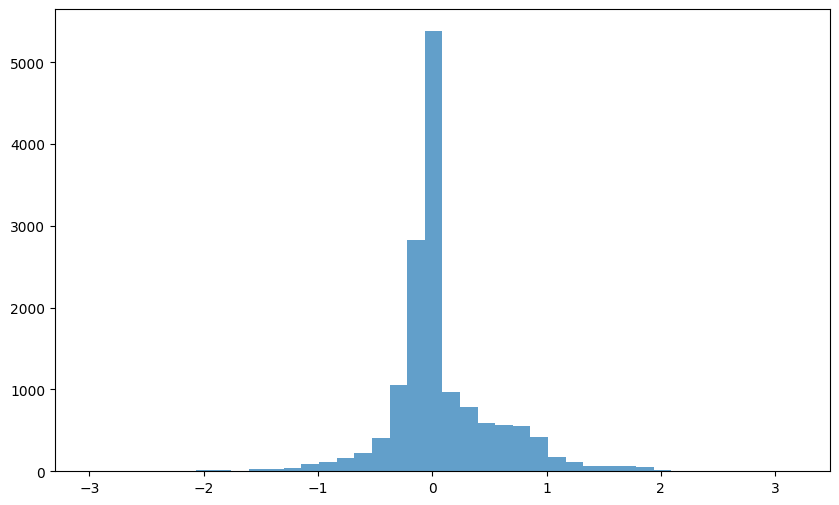

In [28]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

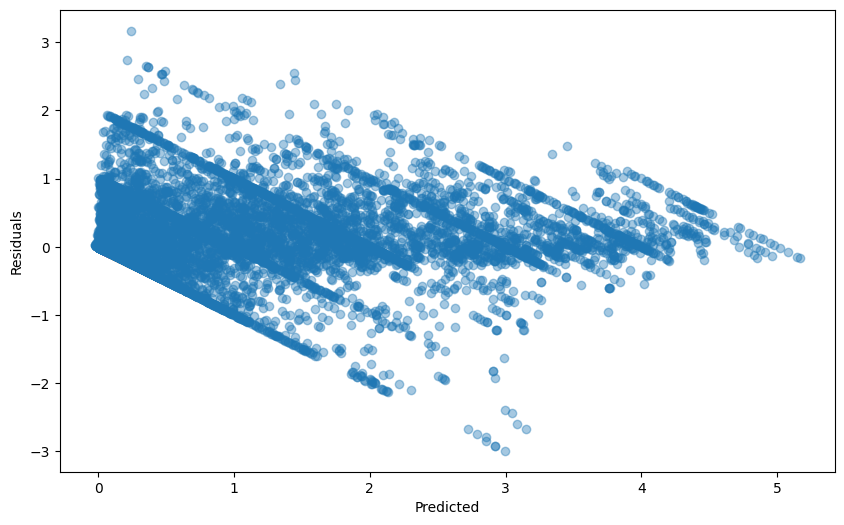

In [29]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

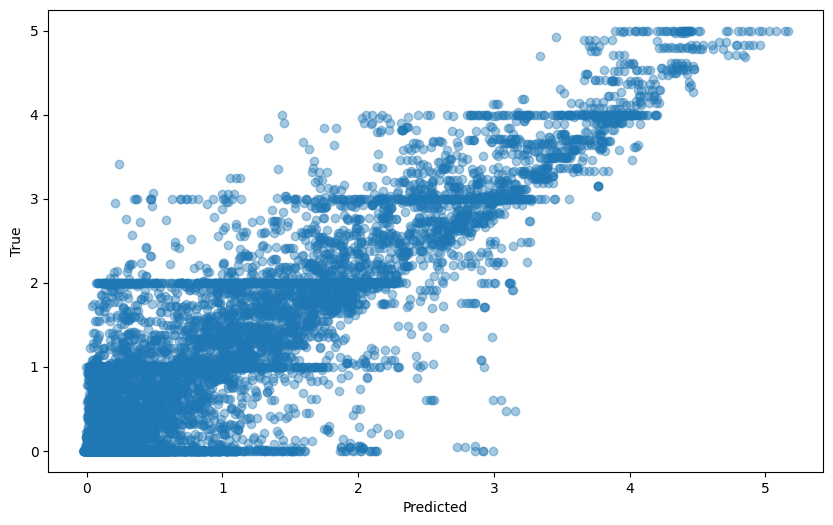

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")